In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import PredictionErrorDisplay ,mean_squared_error

In [2]:
data = pd.read_excel('data_stiffness_SS.xlsx') 

# remove rows with null value
data = data.dropna(how='any',axis=0) 

# select features and target variable
features = data.iloc[:, :-3]  # all columns except the last two
print(features)

#target = data.iloc[:, -3:-2]     # stiffness
target = data.iloc[:, -2:-1]     # specific stiffness
print(target)


          t     theta  theta_hex   plate_N  plate_hex       l_N       h_N  \
0    0.0010  0.639954   0.523599  0.002278   0.004456  0.002792  0.007239   
1    0.0009  1.047198   0.523599  0.004456   0.005000  0.001925  0.005962   
2    0.0010  1.047198   0.698132  0.000100   0.000100  0.001925  0.005962   
3    0.0010  0.814487   0.581776  0.003911   0.005000  0.002292  0.006573   
4    0.0010  0.581776   0.581776  0.001189   0.003367  0.003034  0.007535   
..      ...       ...        ...       ...        ...       ...       ...   
761  0.0002  0.639954   0.698132  0.000100   0.004456  0.005272  0.009228   
762  0.0002  1.047198   0.989020  0.000100   0.003911  0.005346  0.007673   
763  0.0002  0.930842   1.047198  0.000100   0.001733  0.007619  0.009549   
764  0.0003  0.930842   1.047198  0.000100   0.002278  0.007619  0.009549   
765  0.0002  0.814487   1.047198  0.000100   0.003367  0.006365  0.009368   

          l_P       h_P  
0    0.003334  0.002113  
1    0.003334  0.002113

In [3]:
# split data (80% of  dataset into  training set and  other 20% into test data)
X1_train, X1_test, y1_train, y1_test = train_test_split(features, target, test_size = 0.2,random_state=0, shuffle=True)  
#print(X1_train)      #type= pandas.core.frame.DataFrame

In [4]:
# Feature scaling
scaler = StandardScaler()  

X1s_train = scaler.fit_transform(X1_train)  # numpy.ndarray
X1s_test = scaler.transform(X1_test)    # numpy.ndarray

In [6]:
# MLP- Multilayer Perceptron
mlp = MLPRegressor(hidden_layer_sizes=(100,100,100,100), max_iter=10000, batch_size=50 ,learning_rate_init=0.0001, learning_rate='adaptive',solver='adam', activation='tanh')  
mlp.fit(X1s_train, y1_train.values.ravel())

MLPRegressor(activation='tanh', batch_size=50,
             hidden_layer_sizes=(100, 100, 100, 100), learning_rate='adaptive',
             learning_rate_init=0.0001, max_iter=10000)

In [7]:
predictions1 = mlp.predict(X1s_test) 

In [8]:
# Evaluation of algorithm performance

r2=r2_score(y1_test, predictions1)
print(r2)

0.947492970728675


<AxesSubplot:>

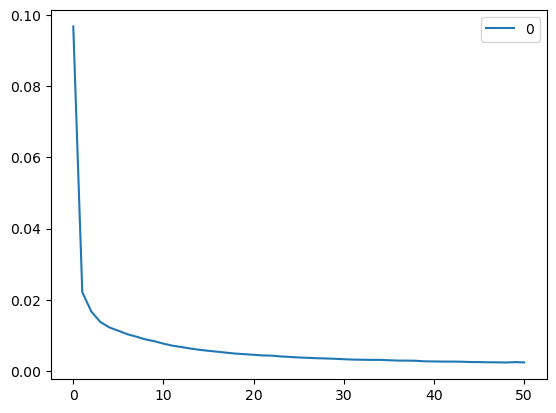

In [9]:
pd.DataFrame(mlp.loss_curve_).plot()

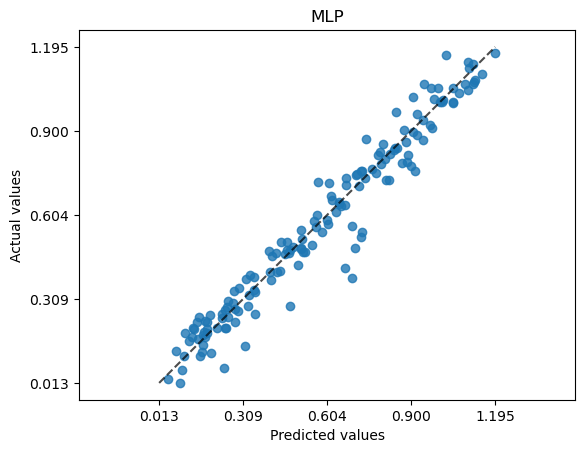

In [10]:
# visualize the prediction error

_, ax = plt.subplots()
PredictionErrorDisplay.from_estimator(mlp, X1s_test, y1_test, kind="actual_vs_predicted", ax=ax)
ax.set_title("MLP")
plt.show()

In [11]:
from SALib.sample import saltelli
from SALib.analyze import sobol


problem = {
    'num_vars': 9,
    'names': [ 't','theta','theta_hex','plate_N','plate_hex','l_N','h_N','l_P','h_P' ],
    'bounds': [[0.001,0.01],
              [0.523599,1.047],
              [0.523599,1.047],
              [0.001,0.005],
              [0.001,0.005],
              [0.001924885, 0.007619],
              [0.005962442,0.009549],
              [0.001925,0.007618532],
              [0.000450527,0.004038]]
}

#If `calc_second_order` is False, the resulting matrix has ``N * (D + 2)`` rows, 
#where ``D`` is the number of parameters. If `calc_second_order` is `True`, the resulting matrix has ``N * (2D + 2)`` rows.
param_values = saltelli.sample(problem, 4096, calc_second_order = True)    

C:\Users\fhassani\AppData\Local\Temp\ipykernel_30660\2060633938.py:21: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 4096, calc_second_order = True)


In [15]:
param_values=scaler.transform(param_values)


C:\Users\fhassani\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [13]:

Y = np.zeros([param_values.shape[0]])
Y = mlp.predict(param_values)    

# Perform Sobol Analysis
Si = sobol.analyze(problem, Y)     


C:\Users\fhassani\AppData\Roaming\Python\Python39\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


C:\Users\fhassani\AppData\Roaming\Python\Python39\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


[                 ST   ST_conf
t          0.356770  0.024331
theta      0.058102  0.003753
theta_hex  0.259854  0.015483
plate_N    0.018286  0.001217
plate_hex  0.009584  0.000778
l_N        0.502026  0.055013
h_N        0.031340  0.002595
l_P        0.056171  0.005160
h_P        0.055794  0.005185,                  S1   S1_conf
t          0.056466  0.039942
theta      0.049008  0.012723
theta_hex  0.248534  0.024604
plate_N    0.008064  0.006807
plate_hex  0.000854  0.004004
l_N        0.239995  0.027761
h_N        0.010980  0.007624
l_P        0.030116  0.010117
h_P        0.032012  0.009770,                               S2   S2_conf
(t, theta)              0.007618  0.059629
(t, theta_hex)          0.003963  0.058154
(t, plate_N)            0.009433  0.059377
(t, plate_hex)          0.011716  0.058678
(t, l_N)                0.239438  0.068301
(t, h_N)                0.010910  0.059478
(t, l_P)                0.005437  0.058420
(t, h_P)                0.016191  0.059514
(theta, th

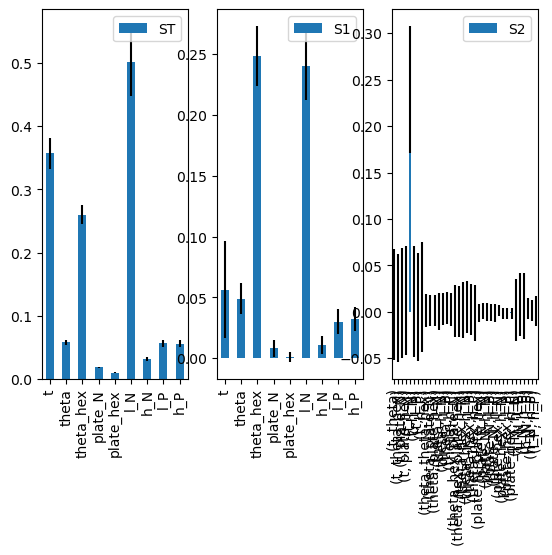

In [14]:
# Turn output to a Pandas DataFrame for further analysis
total_Si, first_Si, second_Si = Si.to_df()
Si.plot()
print(Si.to_df())